# Création des Master Darks à partir des sous-dossiers de temps de pose

Ce notebook parcourt le dossier `darks/`, qui contient des sous-dossiers par temps de pose (ex : `5s`, `14s`, `30s`...).  
Pour chaque temps de pose :
- il lit toutes les images `.fits`,
- calcule la **médiane pixel par pixel**,
- crée un **master dark** correspondant,
- et le sauvegarde dans `master_darks/` sous le nom `master_dark_5s.fits`, etc.

Il affiche également une visualisation et des statistiques pour chaque master dark.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from pathlib import Path
import re

# Dossier principal contenant les sous-dossiers de darks
dark_root = Path('/Volumes/Astro/ohp/CANAGUIER_LOUSTALET_SAPHORES/20250923/Darks')  # à adapter si besoin

# Dossier de sortie pour les master darks
output_dir = Path('master_darks_lyon')
output_dir.mkdir(exist_ok=True)

# Regex pour identifier les sous-dossiers de temps de pose (ex: 5s, 14s, 300s)
exposure_pattern = re.compile(r'^(\d+(?:\.\d+)?)s$', re.IGNORECASE)


Traitement des darks pour 5s (80 fichiers)
Erreur lecture ._Dark-S001-R001-C001-B1.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Erreur lecture ._Dark-S001-R001-C001-B1_dupe-1.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Erreur lecture ._Dark-S001-R001-C002-B1.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Erreur lecture ._Dark-S001-R001-C002-B1_dupe-1.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Erreur lecture ._Dark-S001-R001-C003-B1.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Erreur 

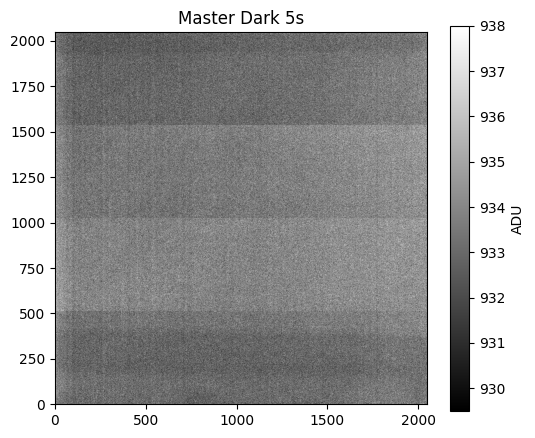

  Moyenne : 933.58 ADU
  Écart-type : 3.27 ADU


In [4]:
# Parcours des sous-dossiers
for subdir in sorted(dark_root.iterdir()):
    if not subdir.is_dir():
        continue

    match = exposure_pattern.match(subdir.name)
    if not match:
        print(f"Ignoré : {subdir.name} (pas un dossier de temps de pose)")
        continue

    exposure_time = match.group(1)
    dark_files = sorted(subdir.glob('*.fits'))

    if len(dark_files) == 0:
        print(f"Aucun fichier .fits trouvé dans {subdir}")
        continue

    print(f"\nTraitement des darks pour {exposure_time}s ({len(dark_files)} fichiers)")

    # Lecture de toutes les images
    dark_data = []
    for file in dark_files:
        try:
            with fits.open(file, ignore_missing_end=True) as hdul:
                data = None
                for hdu in hdul:
                    if hdu.data is not None:
                        data = hdu.data
                        break
                if data is None:
                    raise ValueError('Aucune image trouvée dans le fichier')
                dark_data.append(data.astype(np.float32))
        except Exception as e:
            print(f"Erreur lecture {file.name} : {e}")


    if not dark_data:
        print(f"Aucun dark valide pour {exposure_time}s, ignoré.")
        continue

    # Calcul du master dark
    dark_stack = np.array(dark_data)
    master_dark = np.median(dark_stack, axis=0)

    # Sauvegarde du master dark
    output_file = output_dir / f'master_dark_{exposure_time}s.fits'
    fits.writeto(output_file, master_dark.astype(np.float32), overwrite=True)
    print(f"Master dark sauvegardé : {output_file}")

    # Visualisation
    plt.figure(figsize=(6, 5))
    plt.imshow(master_dark, cmap='gray', origin='lower',
               vmin=np.percentile(master_dark, 5), vmax=np.percentile(master_dark, 95))
    plt.title(f'Master Dark {exposure_time}s')
    plt.colorbar(label='ADU')
    plt.show()

    # Statistiques
    print(f"  Moyenne : {np.mean(master_dark):.2f} ADU")
    print(f"  Écart-type : {np.std(master_dark):.2f} ADU")